In [ ]:
using FDFD, GeometryPrimitives

# Radiating dipole example
This demonstrates a simple dipole radiating in free space.

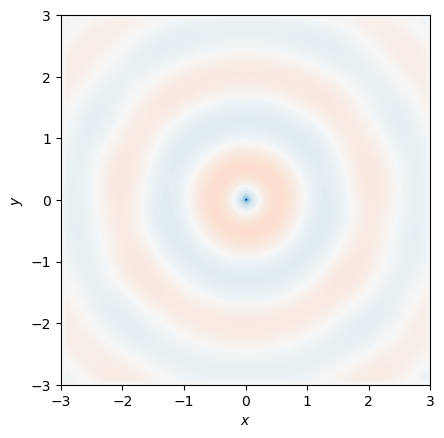

In [2]:
grid0 = Grid(0.01, [15 15], [-3 3], [-3 3]);
dev0  = Device(grid0, 2*π*200e12);
setup_src!(dev0, [0 0]);
field_dipole = solve(dev0);
plot_field(field_dipole,funcz=real);

# Photonic waveguide transition
This demonstrates an indirect photonic mode transition in a waveguide. The even mode is launched from the left and is converted to the odd mode as it propagates.

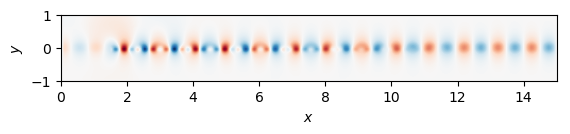

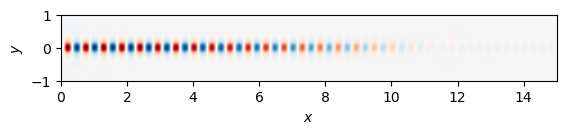

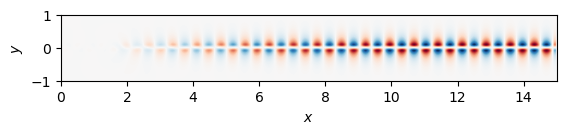

In [3]:
grid1 = Grid(0.01, [15 10], [0.0 15.0], [-1.0 1.0]);
dev1 = ModulatedDevice(grid1, 2π*1.939e14, 4.541e14, 1)

a = 0.2202;
q = 2.9263;

region_wg(x,y) = -a/2<=y<=a/2;
region_modulation(x,y) = 1.5<=x<=11.7 && -a/2<=y<=0;
modulation_function(x,y) = exp.(1im*q*x);

setup_ϵᵣ!(dev1, region_wg, 12.25);
setup_Δϵᵣ!(dev1, region_modulation, modulation_function);
setup_src!(dev1, TM, 3.5, [0.2, 0], DirectionX, 61);

(field_transition, ωn) = solve(dev1);

plot_field(field_transition[1],funcz=real);
plot_field(field_transition[2],funcz=real);
plot_field(field_transition[3],funcz=real);

Here we check that photon number conservation holds. First calculate the input photon number.

In [4]:
Nin = flux_surface(field_transition[2], [1.25,0], Inf, DirectionX)/(2π*1.939e14)

1.3478169151062803e-20

Then check the output photon flux:

In [5]:
Nout = flux_surface(field_transition[3], [11.95,0], Inf, DirectionX)/(4.541e14+2π*1.939e14)+
flux_surface(field_transition[2], [11.95,0], Inf, DirectionX)/(2π*1.939e14)+
flux_surface(field_transition[1], [11.95,0], Inf, DirectionX)/(2π*1.939e14-4.541e14)

1.3507625094589968e-20

Finally, take the ratio. This should be very close to unity:

In [6]:
Nout/Nin

1.002185455843225